# Netflix EDA and Reccomender System

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import plotly.graph_objs as go
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import pickle

## Data Retriving

In [2]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Data Wragling

### Cleaning Data

#### Handling missing values

In [3]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

berdasarkan informasi diatas, terdapat:
- 2634 missing values pada kolom 'director'
- 825 missing values pada kolom 'cast'
- 831 missing values pada kolom 'country'
- 10 missing values pada kolom 'date_added'
- 4 missing values pada kolom 'rating'
- dan 3 missing values pada kolom  'duration'

jiika diperhatikan terdapat banyak sekali missing values. jika kita hilangkan semua kolom yang memiliki missing values, maka banyak sekali informasi yang terbuang.
maka untuk kolom yang memiliki banyak missing values, kami akan mengganti missing values tersebut dengan nilai yang paling sering muncul dengan menggunakan metode .fillna(). untuk kolom yang memiiliki sedikit missing values maka kami akan menghilangkan kolom tersebut dengan metoder .drop().

In [4]:
# kolom dengan banyak missing values
df["director"].fillna(df["director"].mode()[0],inplace=True)
df["cast"].fillna(df["cast"].mode()[0],inplace=True)
df["country"].fillna(df["country"].mode()[0],inplace=True)

In [5]:
# kolom dengan sedikit missing values
df.dropna(subset=['date_added','rating','duration'],inplace=True)

In [6]:
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

sekarang sudah tidak terdapat missing values

#### Handling Duplicated Data

In [7]:
df.duplicated().sum()

0

dari informasi diatas, tidak terdapat data yang berduplikat

### Integration Data

#### Handling Data Type

pada tahap ini kami akan memeriksa apakah ada perbedaan dalam tipe data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   cast          8790 non-null   object
 5   country       8790 non-null   object
 6   date_added    8790 non-null   object
 7   release_year  8790 non-null   int64 
 8   rating        8790 non-null   object
 9   duration      8790 non-null   object
 10  listed_in     8790 non-null   object
 11  description   8790 non-null   object
dtypes: int64(1), object(11)
memory usage: 892.7+ KB


dari informasi diatas, kami menemukan kejanggalan yaitu:
- pada kolom 'date_added' memiliki tipe data object. agar lebih spesifik dan akurat, kami akan mengganti tipe data tersebut menjadi 'date_time'

In [9]:
datetime_column = ['date_added']
for column in datetime_column:
    df[column] = pd.to_datetime(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   director      8790 non-null   object        
 4   cast          8790 non-null   object        
 5   country       8790 non-null   object        
 6   date_added    8790 non-null   datetime64[ns]
 7   release_year  8790 non-null   int64         
 8   rating        8790 non-null   object        
 9   duration      8790 non-null   object        
 10  listed_in     8790 non-null   object        
 11  description   8790 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 892.7+ KB



## EDA dan Data Visualization

pada tahap ini kami akan melakukan EDA (Exploratory Data Analysis) untuk memahami karakteristik data dan menemukan insight dari dataframe kami

In [10]:
df.describe(include='all')

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
count,8790,8790,8790,8790,8790,8790,8790,8790.000000,8790,8790,8790,8790
unique,8790,2,8790,4526,7678,748,1713,NaN,14,220,513,8758
top,s1,Movie,Dick Johnson Is Dead,Rajiv Chilaka,David Attenborough,United States,2020-01-01 00:00:00,NaN,TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6126,1,2640,844,3638,110,NaN,3205,1791,362,4
first,NaN,NaN,NaN,NaN,NaN,NaN,2008-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.183163,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.825466,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN,NaN,NaN,NaN


berdasarkan informasi diata, didapatkan infomasi:
- terdapat 8790 jumlah konten yang terdapat dalam dataframe.
- terdapat 2 jenis tipe konten dalam dataframe.
- konten netflix ditambahkan paling tertua yaitu pada tahun 1925, dan terbaru yaitu pada tahun 2021.
- konten netflix ditambahkan rata-rata pada tahun 2014.

untuk mendapatkan insight data lebih lanjut, kami akan mengekplorasi data berdasarkan beberapa poin, seperti :
- analisis konten tahunan
- Genre, rirector,cast yang paling populer
- Tipe konten yang paling sering Muncul
- Analisis Tipe Konten

### Analisis Konten Tahunan

In [11]:
df.groupby(by='release_year').type.count().sort_values(ascending=False).reset_index().head(15)

,release_year,type
0,2018,1146
1,2019,1030
2,2017,1030
3,2020,953
4,2016,901
5,2021,592
6,2015,555
7,2014,352
8,2013,286
9,2012,236


Text(0, 0.5, 'Year')

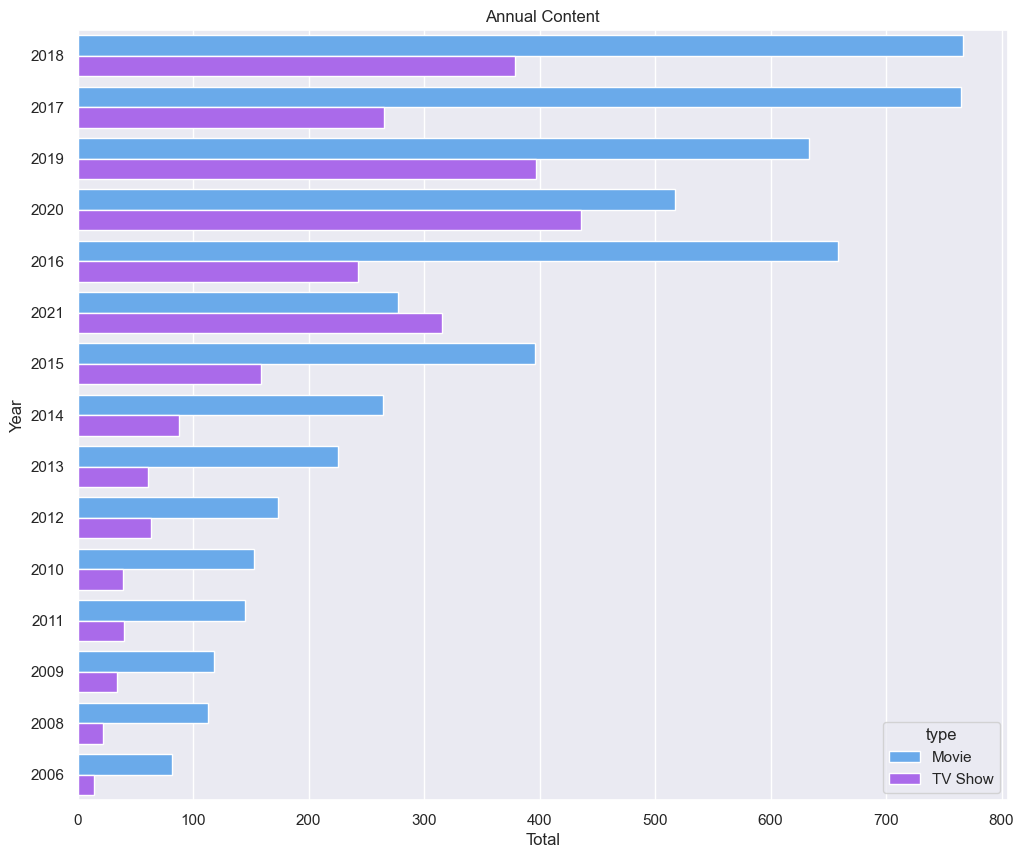

In [12]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
sns.countplot(y="release_year", data= df, palette="cool", order= df['release_year'].value_counts().index[0:15],hue=df['type'])
plt.title('Annual Content')
plt.xlabel('Total')
plt.ylabel('Year')

berdasarkan infomrasi diatas, dapat disimpulkan bahwa:
- Netflix merilis konten terbanyak pada tahun 2018.
- Pertumbuhan signifikan terjadi mulai pada tahun 2015.

### Genre, Director, dan Cast Paling Populer

#### genre yang paling populer

In [13]:
# memisahkan tiap value
genres=list(df['listed_in'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
   
g=Counter(gen)

genres=list(df['listed_in'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))


dic_order = dict(sorted(g.items(), key=lambda item: item[1]))
dic_order

data1 = {
    'Genre': list(dic_order.keys()),
    'Total': list(dic_order.values())
}

popular_genre_df = pd.DataFrame(data1).sort_values(by='Total', ascending=False)
popular_genre_df.head(10)


,Genre,Total
41,InternationalMovies,2752
40,Dramas,2426
39,Comedies,1674
38,InternationalTVShows,1349
37,Documentaries,869
36,Action&Adventure,859
35,TVDramas,762
34,IndependentMovies,756
33,Children&FamilyMovies,641
32,RomanticMovies,616


In [14]:
colors =  ['#660000', '#990000', '#CC0000', '#FF0000', '#FF3333']

fig = px.sunburst(popular_genre_df.head(10), path=['Genre'], values='Total', color_discrete_sequence=colors)
fig.update_layout(title_text="Most Popular Genre")
fig.show()

dari informasi diatas dapat disimpulkan bahwa InternationalMovies	merupakan genre yang paling populer dengan jumlah 2752

#### Director yang paling populer

In [15]:
df.groupby(by='director').show_id.nunique().sort_values(ascending=False).reset_index().rename(columns={
    'show_id':'total_shows'
}).head(10)

,director,total_shows
0,Rajiv Chilaka,2640
1,"Raúl Campos, Jan Suter",18
2,Suhas Kadav,16
3,Marcus Raboy,16
4,Jay Karas,14
5,Cathy Garcia-Molina,13
6,Jay Chapman,12
7,Youssef Chahine,12
8,Martin Scorsese,12
9,Steven Spielberg,11


Text(0, 0.5, 'Directors')

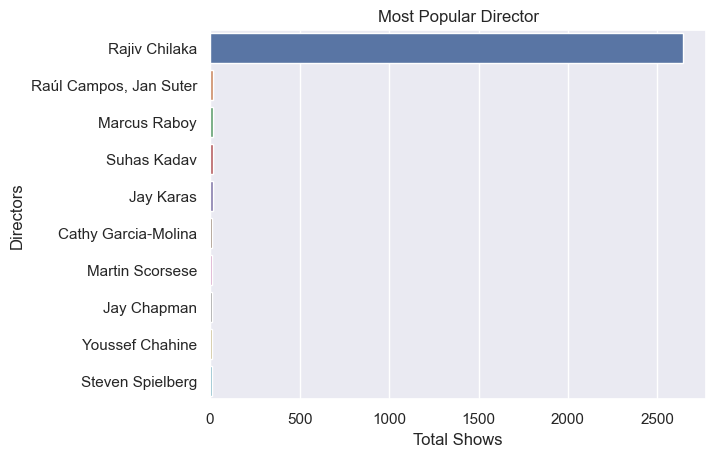

In [16]:
sns.countplot(
    y= 'director',
    data = df,
    order = df['director'].value_counts().index[0:10]
)
plt.title('Most Popular Director')
plt.xlabel('Total Shows')
plt.ylabel('Directors')

berdasarkan informasi diatas dapat disimpulkan bahwa bahwa Rajiv Chilaka merupakan director paling populer dengan 2640 total show.

#### Cast paling populer

In [17]:
# memisahkan tiap value
genres=list(df['cast'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
   
g=Counter(gen)

genres=list(df['cast'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))


dic_order = dict(sorted(g.items(), key=lambda item: item[1]))
dic_order

data1 = {
    'cast': list(dic_order.keys()),
    'total_show': list(dic_order.values())
}

popular_cast_df = pd.DataFrame(data1).sort_values(by='total_show', ascending=False)
popular_cast_df.head(10)

,cast,total_show
36387,DavidAttenborough,845
36386,AnupamKher,43
36385,ShahRukhKhan,35
36384,JulieTejwani,33
36383,TakahiroSakurai,32
36382,NaseeruddinShah,32
36381,RupaBhimani,31
36380,OmPuri,30
36379,AkshayKumar,30
36378,YukiKaji,29


In [18]:
colors =  ['#00A9FF','#89CFF3','#A0E9FF','#CDF5FD']

fig = px.sunburst(popular_cast_df.head(10), path=['cast'], values='total_show', color_discrete_sequence=colors)
fig.update_layout(title_text="Most Popular Cast")
fig.show()

dari informasi diatas dapat disimpulkan bahwa DavidAttenborough merupakan cast paling popular dengan 845 total show

### Rating Paling Sering Muncul

In [19]:
df['rating'].value_counts().reset_index()

,index,rating
0,TV-MA,3205
1,TV-14,2157
2,TV-PG,861
3,R,799
4,PG-13,490
5,TV-Y7,333
6,TV-Y,306
7,PG,287
8,TV-G,220
9,NR,79


Text(0, 0.5, 'Total')

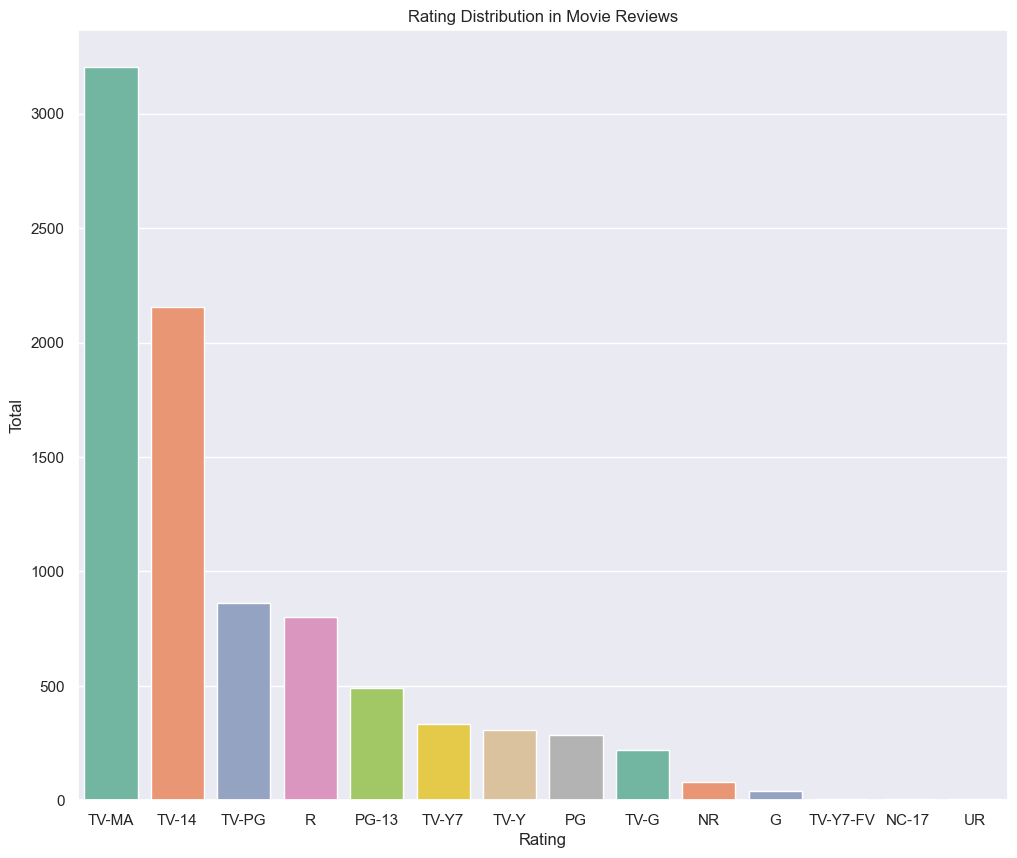

In [20]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
sns.countplot(x="rating", data= df, palette="Set2", order=df['rating'].value_counts().index[0:15])
plt.title('Rating Distribution in Movie Reviews')
plt.xlabel('Rating')
plt.ylabel('Total')

berdasarkan informasi diatas dapat disimpukan:
- Jumlah film terbanyak dibuat dengan rating 'TV-MA'. "TV-MA" adalah rating yang diberikan oleh Pedoman Orang Tua TV untuk program televisi yang dirancang untuk penonton dewasa saja.
- Yang terbesar kedua adalah 'TV-14' yang berarti konten yang mungkin tidak pantas untuk anak-anak di bawah usia 14 tahun.

### Tipe Konten Paling Sering Muncul

In [21]:
type_df = df.groupby(by='type').show_id.nunique().sort_values(ascending=False).reset_index()
type_df.rename(columns={
    'show_id':'total'
},inplace=True)
type_df.head()

,type,total
0,Movie,6126
1,TV Show,2664


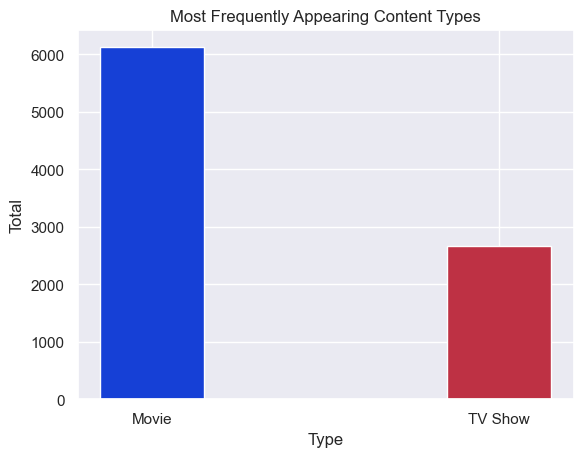

In [22]:
plt.bar(
    x= 'type',
    height = 'total',
    width=0.3,
    data= type_df,
    color=['#1640D6','#BE3144']
)
plt.title('Most Frequently Appearing Content Types')
plt.xlabel('Type')
plt.ylabel('Total')
plt.show()

berdasarkan informasi diatas, dapat disimpulkan bahwa tipe konten Movie merupakan tipe konten yang paling sering muncul dengan total 6162

### Analisis Tipe Konten

untuk menganalisis tipe konten, pertama-tama kami akan membuat dataframe baru berdasarkan tipe kontennya

In [23]:
movie_df = df[df['type'] == 'Movie']
tv_df = df[df['type'] == 'TV Show']

In [24]:
movie_df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,David Attenborough,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",United States,2021-09-24,2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."


In [25]:
tv_df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,TV Show,Blood & Water,Rajiv Chilaka,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,Rajiv Chilaka,David Attenborough,United States,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."


dari 2 dataframe baru tersebut kita bisa:
- Melihat Kepadatan distribusi dari durasi movie
- Melihat Tren dari durasi movie
- Melihat TV show dengan season paling banyak
- Melihat pembagian TV show berdasarkan seasonnya

#### Kepadatan Distribusi Durasi Movie

In [26]:
movie_df['duration']=movie_df['duration'].str.replace(' min','')
movie_df['duration']=movie_df['duration'].astype(str).astype(int)
movie_df['duration'].reset_index()

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\4065627269.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\4065627269.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,duration
0,0,90
1,6,91
2,7,125
3,9,104
4,12,127
...,...,...
6121,8801,96
6122,8802,158
6123,8804,88
6124,8805,88


Text(0, 0.5, 'Density')

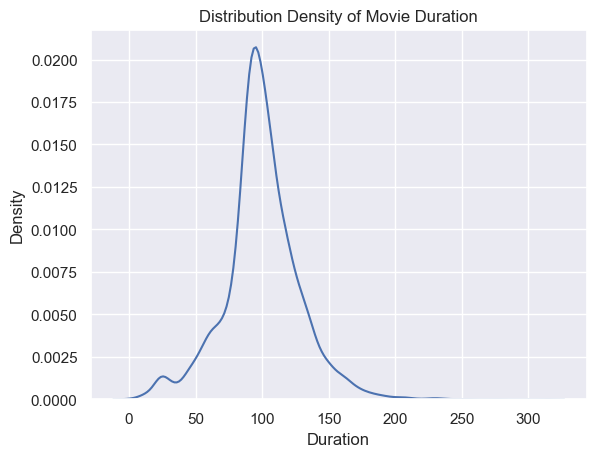

In [27]:
sns.set(style="darkgrid")
sns.kdeplot(data=movie_df['duration'])
plt.title('Distribution Density of Movie Duration')
plt.xlabel('Duration')
plt.ylabel('Density')

dapat disimpulkan bahwa sebagian besar film di Netflix berdurasi antara 75-120 menit.

#### Tren Durasi Movie

In [28]:
duration_year = movie_df.groupby(['release_year']).mean()
duration_year = duration_year.sort_index()
duration_year.head(10)

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\42638668.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,duration
release_year,
1942,35.000000
1943,62.666667
1944,52.000000
1945,51.333333
1946,58.000000
1947,42.000000
1954,118.000000
1955,100.333333
1956,101.000000


Text(0.5, 1.0, "Trends of Movie's Duration over the Years")

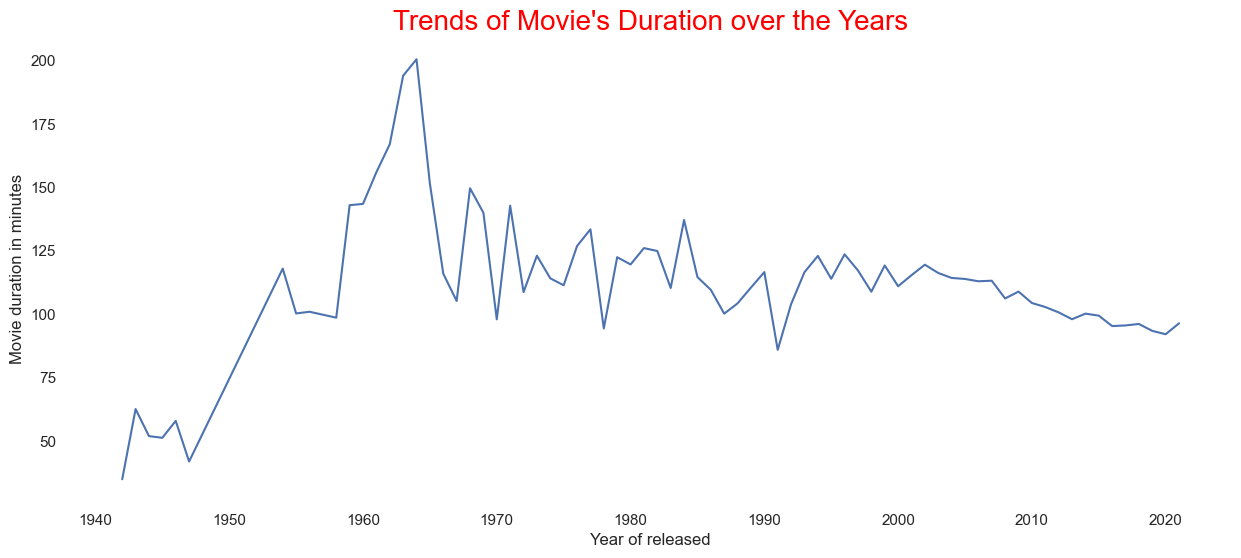

In [29]:
plt.figure(figsize=(15,6))
sns.lineplot(x=duration_year.index, y=duration_year.duration.values)
plt.box(on=None)
plt.ylabel('Movie duration in minutes')
plt.xlabel('Year of released')
plt.title("Trends of Movie's Duration over the Years", fontsize=20, color='Red')

Berdasarkan informasi diatas dapat disimpulkan :
- Pada tahun 1960 hingga 1965, durasi film lebih dari 200 menit, setelah tahun 1965 durasinya menjadi relatif lebih pendek.
- Sejak tahun 1980, kita dapat melihat tren durasi film yang konsisten, dengan durasi berkisar antara 100-150 menit.

#### TV show dengan Season Paling Banyak

In [30]:
tv_df['duration']=tv_df['duration'].str.replace(' Season','')
tv_df['duration']=tv_df['duration'].str.replace('s','')
tv_df['duration']=tv_df['duration'].astype(str).astype(int)
tv_df['duration'].reset_index()

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\2836404651.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\2836404651.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nafi Kareem\AppData\Local\Temp\ipykernel_7824\2836404651.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,index,duration
0,1,2
1,2,1
2,3,1
3,4,2
4,5,1
...,...,...
2659,8795,2
2660,8796,2
2661,8797,3
2662,8800,1


In [31]:
columns=['title','duration']
tv_shows = tv_df[columns]
tv_shows = tv_shows.sort_values(by='duration',ascending=False)
tv_shows.head(10)

,title,duration
548,Grey's Anatomy,17
2423,Supernatural,15
4798,NCIS,15
4220,COMEDIANS of the world,13
1354,Heartland,13
4964,Trailer Park Boys,12
5412,Criminal Minds,12
6456,Cheers,11
390,The Walking Dead,10
1622,Stargate SG-1,10


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, "Grey's Anatomy"),
  Text(1, 0, 'Supernatural'),
  Text(2, 0, 'NCIS'),
  Text(3, 0, 'COMEDIANS of the world'),
  Text(4, 0, 'Heartland'),
  Text(5, 0, 'Trailer Park Boys'),
  Text(6, 0, 'Criminal Minds'),
  Text(7, 0, 'Cheers'),
  Text(8, 0, 'The Walking Dead'),
  Text(9, 0, 'Stargate SG-1')])

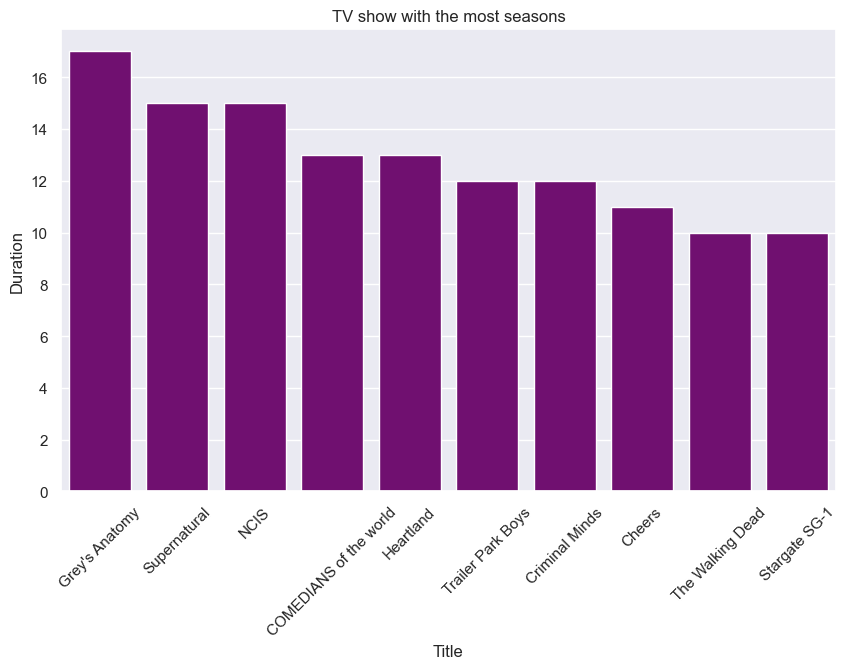

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(x='title',y='duration', color='purple',data=tv_shows.head(10))
plt.title('TV show with the most seasons')
plt.xlabel('Title')
plt.ylabel('Duration')
plt.xticks(rotation=45)

berdasarkan informasi diatas dapat disimpulkan bahwa Grey's Anatomy memiliki jumlah season terbanyak yaitu sebanyak 17 Season

#### Pembagian Season TV Show

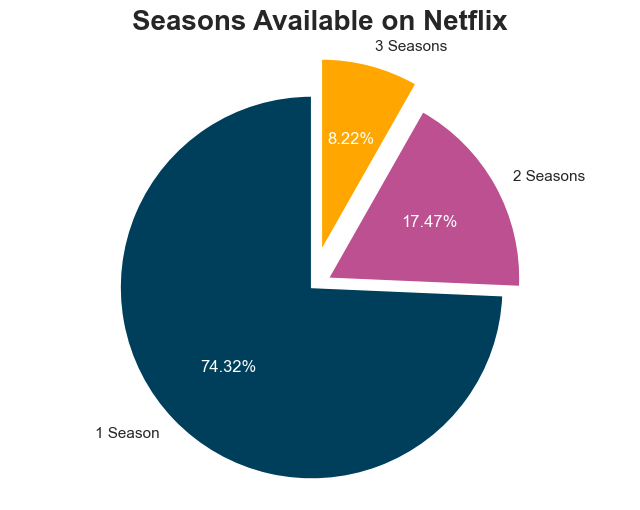

In [33]:
plt.figure(figsize=(8, 6))
labels=['1 Season', '2 Seasons', '3 Seasons']
_, _, texts = plt.pie(df.duration.value_counts()[:3], labels=labels, autopct='%1.2f%%', startangle=90, 
                      explode=(0.0, 0.1, 0.2), colors=['#003f5c', '#bc5090', '#ffa600'])
plt.axis('equal')
plt.title('Seasons Available on Netflix', fontsize=20, fontweight='bold');
for text in texts:
    text.set_color('white')

dari informasi diatas dapat disimpulkan bahwa:
- 74.32% TV show hanya memiliki 1 season
- 17.47% TV show memiliki 2 seasons
-  8.22% TV show memiliki 3 seasons

## Data Preprocessing

pada tahap ini kami akan melakukan preprocessing sebelum membuat model machine learning. kami akan menggunakan beberapa fitur untuk mengukur kemiripan, diantaranya :
- type
- title
- listed in
- director
- description

In [34]:
def bag_of_words(df):
    features = df['type']+' '+df['title']+' '+df['listed_in']+' '+df['director']+' '+df['description']
    return features.str.lower()

In [35]:
features = bag_of_words(df)

In [36]:
features.head(10)

0    movie dick johnson is dead documentaries kirst...
1    tv show blood & water international tv shows, ...
2    tv show ganglands crime tv shows, internationa...
3    tv show jailbirds new orleans docuseries, real...
4    tv show kota factory international tv shows, r...
5    tv show midnight mass tv dramas, tv horror, tv...
6    movie my little pony: a new generation childre...
7    movie sankofa dramas, independent movies, inte...
8    tv show the great british baking show british ...
9    movie the starling comedies, dramas theodore m...
dtype: object

### mengubah data kategorik menjadi data numerik

karena tipe data kami bertipe kategorik, maka kami perlu mengubah data kategorik menjadi numerik. karena kita akan menggunakan model CSM (Cosine Similarity Metric) maka kita akan menggunakan fungsi CountVectorizer. CountVectorizer simple nya akan mengubah data kategorik menjadi sebuah vektor yang berisi frekuensi kemunculan setiap kata dalam data tersebut.

In [37]:
countvec = CountVectorizer(stop_words='english')
countvec

CountVectorizer(stop_words='english')

In [38]:
count_matrix = countvec.fit_transform(features)

In [39]:
count_matrix.shape

(8790, 27232)

### standarisadi data

karena fitur yang digunakan untuk mengukur kemiripan film berbentuk teks, maka kami perlu menstandarisasi data karena fitur teks memiliki skala yang berbeda-beda, tergantung pada frekuensi kemunculan kata dalam teks. kali ini kami akan menggunakan standardcaler karena algoritma CSM tidak terlalu sensitif pada skala data

In [40]:
scaler = StandardScaler(with_mean=False)
scaler

StandardScaler(with_mean=False)

In [41]:
scaled_data = scaler.fit_transform(count_matrix)

In [42]:
scaled_data.shape

(8790, 27232)

## Modelling

pada tahap ini kami akanmembuat model dengan menggunakan metode Cosine Similarity Metric (CSM). simplenya CSM akan mengukur kesamaan antara dua vektor. Nilai cosine similarity metric berkisar antara 0 dan 1. Nilai 0 menunjukkan bahwa kedua vektor sangat berbeda, sedangkan nilai 1 menunjukkan bahwa kedua vektor sangat mirip.

In [43]:
cosine_sim = cosine_similarity(scaled_data)
cosine_sim

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.43681498e-04, 5.42608522e-04, 1.87111356e-04],
       [0.00000000e+00, 1.00000000e+00, 1.21039410e-03, ...,
        0.00000000e+00, 0.00000000e+00, 6.26544479e-04],
       [0.00000000e+00, 1.21039410e-03, 1.00000000e+00, ...,
        0.00000000e+00, 2.72151024e-04, 4.88255231e-04],
       ...,
       [1.43681498e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 3.28378673e-04, 2.03568796e-04],
       [5.42608522e-04, 0.00000000e+00, 2.72151024e-04, ...,
        3.28378673e-04, 1.00000000e+00, 4.86354977e-04],
       [1.87111356e-04, 6.26544479e-04, 4.88255231e-04, ...,
        2.03568796e-04, 4.86354977e-04, 1.00000000e+00]])

mengubah kolom title dari data menjadi list.

In [44]:
programme_list=df['title'].to_list()
programme_list

['Dick Johnson Is Dead',
 'Blood & Water',
 'Ganglands',
 'Jailbirds New Orleans',
 'Kota Factory',
 'Midnight Mass',
 'My Little Pony: A New Generation',
 'Sankofa',
 'The Great British Baking Show',
 'The Starling',
 'Vendetta: Truth, Lies and The Mafia',
 'Bangkok Breaking',
 'Je Suis Karl',
 'Confessions of an Invisible Girl',
 'Crime Stories: India Detectives',
 'Dear White People',
 "Europe's Most Dangerous Man: Otto Skorzeny in Spain",
 'Falsa identidad',
 'Intrusion',
 'Jaguar',
 'Monsters Inside: The 24 Faces of Billy Milligan',
 'Resurrection: Ertugrul',
 'Avvai Shanmughi',
 'Go! Go! Cory Carson: Chrissy Takes the Wheel',
 'Jeans',
 'Love on the Spectrum',
 'Minsara Kanavu',
 'Grown Ups',
 'Dark Skies',
 'Paranoia',
 'Ankahi Kahaniya',
 'Chicago Party Aunt',
 'Sex Education',
 'Squid Game',
 'Tayo and Little Wizards',
 'The Father Who Moves Mountains',
 'The Stronghold',
 'Angry Birds',
 'Birth of the Dragon',
 'Chhota Bheem',
 'He-Man and the Masters of the Universe',
 'Jaws

membuat fungsi baru bernama reccomend 

In [45]:
def recommend(title, cosine_similarity=cosine_sim): # membuat fungsi dengan 2 parameter title (Judul film yang ingin direkomendasikan), cosine_similarity (cosine similarity antar film)
    index = programme_list.index(title)
    sim_score = list(enumerate(cosine_sim[index]))
    sim_score = sorted(sim_score, key= lambda x: x[1], reverse=True)[1:11] 
    recommend_index = [i[0] for i in sim_score]
    rec_movie = df['title'].iloc[recommend_index]
    rec_score = [round(i[1],4) for i in sim_score]
    rec_table = pd.DataFrame(list(zip(rec_movie,rec_score)), columns=['Recommend','Similarity(0-1)'])
    return rec_table

pengujian model

In [46]:
recommend('Yowamushi Pedal')

,Recommend,Similarity(0-1)
0,The Least Expected Day: Inside the Movistar Te...,0.1629
1,Accomplice,0.1383
2,Pedal the World,0.1272
3,A Flying Jatt,0.0685
4,Isa Pa with Feelings,0.0534
5,My Mister,0.0530
6,Daughter From Another Mother,0.0515
7,Hasmukh,0.0509
8,She,0.0498
9,I Don't Feel at Home in This World Anymore,0.0474


In [47]:
recommend('Indiana Jones and the Last Crusade')

,Recommend,Similarity(0-1)
0,Indiana Jones and the Temple of Doom,0.2204
1,Indiana Jones and the Raiders of the Lost Ark,0.1975
2,Cradle 2 the Grave,0.1860
3,Monty Python and the Holy Grail,0.1789
4,Painted Faces,0.1593
5,Indiana Jones and the Kingdom of the Crystal S...,0.1529
6,Pajanimals,0.1458
7,The Signal,0.1271
8,Django Unchained,0.1228
9,Green Zone,0.1191


In [48]:
recommend('Naruto Shippuden the Movie: Blood Prison')

,Recommend,Similarity(0-1)
0,Naruto Shippuden : Blood Prison,0.9999
1,Naruto Shippuden: The Movie: The Lost Tower,0.3182
2,Naruto Shippûden the Movie: The Will of Fire,0.1896
3,Ghost Pain,0.1301
4,Naruto Shippuden: The Movie,0.1296
5,Tremors 4: The Legend Begins,0.1252
6,InuYasha the Movie: Affections Touching Across...,0.0966
7,Den of Thieves,0.0936
8,Deuces,0.0890
9,The Seven Deadly Sins the Movie: Prisoners of ...,0.0752


In [49]:
pickle.dump(df,open('netflix.pkl', 'wb'))

In [50]:
pickle.dump(cosine_sim,open('cosine_sim.pkl', 'wb'))

In [51]:
pickle.load(open('netflix.pkl','rb'))

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,David Attenborough,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,Rajiv Chilaka,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,Rajiv Chilaka,David Attenborough,United States,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Rajiv Chilaka,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,Rajiv Chilaka,David Attenborough,United States,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [52]:
pickle.load(open('cosine_sim.pkl', 'rb'))

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.43681498e-04, 5.42608522e-04, 1.87111356e-04],
       [0.00000000e+00, 1.00000000e+00, 1.21039410e-03, ...,
        0.00000000e+00, 0.00000000e+00, 6.26544479e-04],
       [0.00000000e+00, 1.21039410e-03, 1.00000000e+00, ...,
        0.00000000e+00, 2.72151024e-04, 4.88255231e-04],
       ...,
       [1.43681498e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 3.28378673e-04, 2.03568796e-04],
       [5.42608522e-04, 0.00000000e+00, 2.72151024e-04, ...,
        3.28378673e-04, 1.00000000e+00, 4.86354977e-04],
       [1.87111356e-04, 6.26544479e-04, 4.88255231e-04, ...,
        2.03568796e-04, 4.86354977e-04, 1.00000000e+00]])